# Google Colab Lab Assignment 5.3 - Sequence Text Classification using LSTM

**Course Name:** PEC Deep Learning

**Lab Title:** To forecast future values of a univariate time series using LSTM-based models.

**Student Name:** Harshad Jadhav

**Student ID:** 202201040081

**Date of Submission:** 26/04/2025



**Objective**

To classify text sequences using LSTM-based models.
The task involves sentiment classification using the Amazon Sentiment Analysis dataset.




 #  1. Import Required Libraries

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


#  2. Load and Inspect Dataset

In [19]:
import pandas as pd

# Load the Amazon Reviews CSV
df = pd.read_csv('/content/Reviews.csv')

# Set column names
df.columns = [
    'Id', 'ProductId', 'UserId', 'ProfileName',
    'HelpfulnessNumerator', 'HelpfulnessDenominator',
    'Score', 'Time', 'Summary', 'Text'
]

# 1. Create Sentiment based on Score
def get_sentiment(score):
    if score >= 4:
        return 1  # Positive
    elif score <= 2:
        return 0  # Negative
    else:
        return None  # Neutral, we will drop later

df['Sentiment'] = df['Score'].apply(get_sentiment)

# 2. Drop rows where Sentiment or Text is missing
df.dropna(subset=['Text', 'Sentiment'], inplace=True)

# 3. Convert Sentiment to integer type (optional)
df['Sentiment'] = df['Sentiment'].astype(int)

# 4. Extract features and labels
texts = df['Text'].values
labels = df['Sentiment'].values

# Check few samples
print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
Index: 525814 entries, 0 to 568453
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      525814 non-null  int64 
 1   ProductId               525814 non-null  object
 2   UserId                  525814 non-null  object
 3   ProfileName             525788 non-null  object
 4   HelpfulnessNumerator    525814 non-null  int64 
 5   HelpfulnessDenominator  525814 non-null  int64 
 6   Score                   525814 non-null  int64 
 7   Time                    525814 non-null  int64 
 8   Summary                 525789 non-null  object
 9   Text                    525814 non-null  object
 10  Sentiment               525814 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 48.1+ MB
None


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1


#  3. Preprocess the Dataset

In [20]:
from sklearn.preprocessing import LabelEncoder

# Drop rows with missing values in Text or Sentiment columns
df.dropna(subset=['Text', 'Sentiment'], inplace=True)

label_encoder = LabelEncoder()
df['Sentiment'] = label_encoder.fit_transform(df['Sentiment'])

# Extract features (texts) and labels
texts = df['Text'].values
labels = df['Sentiment'].values


#  4. Tokenization and Padding


In [21]:
# Tokenization parameters
vocab_size = 10000
max_length = 100
oov_token = "<OOV>"
padding_type = 'post'
trunc_type = 'post'


tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


#  5. Split the Data



In [22]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))


Training samples: 420651
Testing samples: 105163


#  6. Build the LSTM Model

In [23]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))  # 3 classes: Positive, Negative, Neutral

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#  7. Train the Model with Callbacks

In [24]:
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
mc = ModelCheckpoint('best_Review_lstm.h5', save_best_only=True, monitor='val_loss', verbose=1)

history = model.fit(X_train, y_train,
                    validation_split=0.1,
                    epochs=10,
                    batch_size=32,
                    callbacks=[es, mc],
                    verbose=1)


Epoch 1/10
11830/11831 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8843 - loss: 0.3188
Epoch 1: val_loss improved from inf to 0.13493, saving model to best_Review_lstm.h5


11831/11831 ━━━━━━━━━━━━━━━━━━━━ 106s 9ms/step - accuracy: 0.8843 - loss: 0.3188 - val_accuracy: 0.9475 - val_loss: 0.1349
Epoch 2/10
11825/11831 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9589 - loss: 0.1139
Epoch 2: val_loss improved from 0.13493 to 0.11592, saving model to best_Review_lstm.h5


11831/11831 ━━━━━━━━━━━━━━━━━━━━ 146s 9ms/step - accuracy: 0.9589 - loss: 0.1139 - val_accuracy: 0.9573 - val_loss: 0.1159
Epoch 3/10
11831/11831 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9704 - loss: 0.0833
Epoch 3: val_loss improved from 0.11592 to 0.11380, saving model to best_Review_lstm.h5


11831/11831 ━━━━━━━━━━━━━━━━━━━━ 145s 9ms/step - accuracy: 0.9704 - loss: 0.0833 - val_accuracy: 0.9591 - val_loss: 0.1138
Epoch 4/10
11830/11831 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9781 - loss: 0.0621
Epoch 4: val_loss did not improve from 0.11380
11831/11831 ━━━━━━━━━━━━━━━━━━━━ 103s 9ms/step - accuracy: 0.9781 - loss: 0.0621 - val_accuracy: 0.9603 - val_loss: 0.1166
Epoch 5/10
11827/11831 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9838 - loss: 0.0483
Epoch 5: val_loss did not improve from 0.11380
11831/11831 ━━━━━━━━━━━━━━━━━━━━ 142s 9ms/step - accuracy: 0.9838 - loss: 0.0483 - val_accuracy: 0.9604 - val_loss: 0.1270
Epoch 6/10
11826/11831 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9881 - loss: 0.0368
Epoch 6: val_loss did not improve from 0.11380
11831/11831 ━━━━━━━━━━━━━━━━━━━━ 104s 9ms/step - accuracy: 0.9881 - loss: 0.0369 - val_accuracy: 0.9606 - val_loss: 0.1474
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


# 8. Evaluate the Model

In [25]:
# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-score: {f1:.4f}")


3287/3287 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
Accuracy: 0.9599
Precision: 0.9596
F1-score: 0.9597


#  9. Confusion Matrix

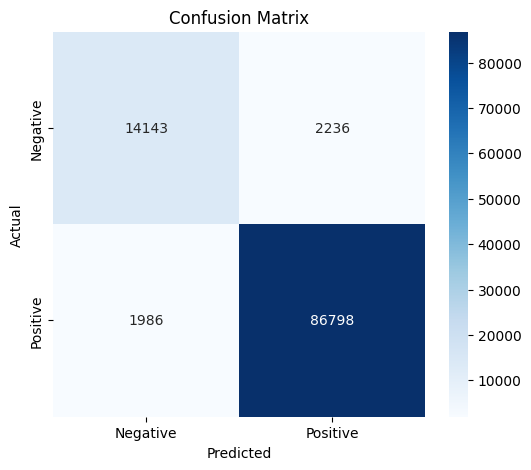


Classification Report:

              precision    recall  f1-score   support

    Negative       0.88      0.86      0.87     16379
    Positive       0.97      0.98      0.98     88784

    accuracy                           0.96    105163
   macro avg       0.93      0.92      0.92    105163
weighted avg       0.96      0.96      0.96    105163



In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Negative', 'Positive'],  # Your classes here
            yticklabels=['Negative', 'Positive'])  # Your classes here
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))  # Specify class names manually


# 10. Accuracy & Loss Curves (Training vs Validation)

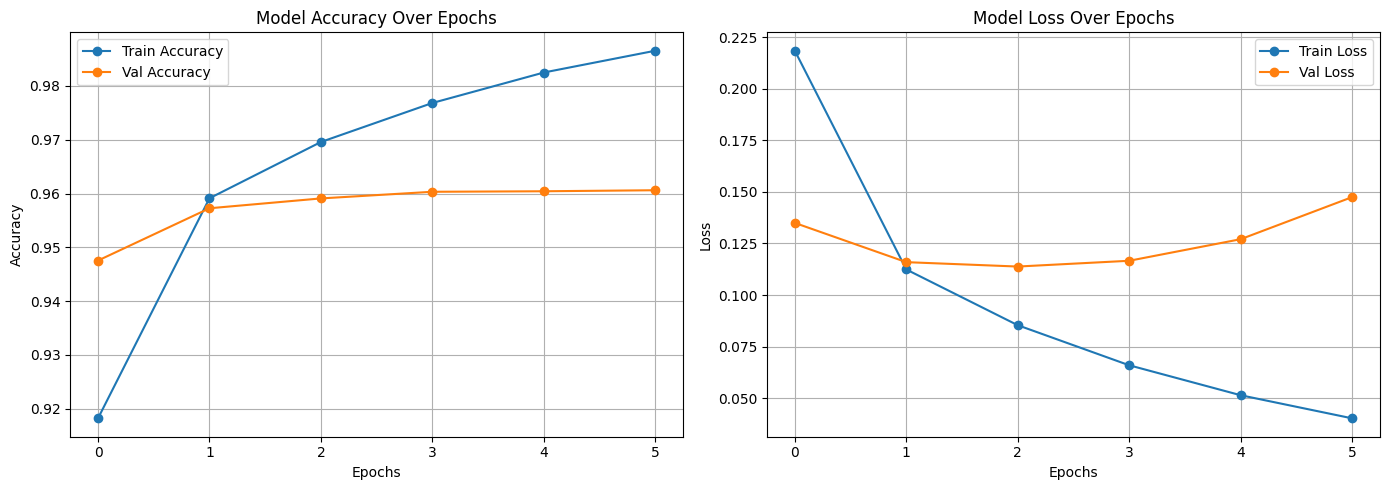

In [27]:
# Plot Accuracy and Loss over epochs
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# 11. Classification Report as a DataFrame (Pretty Table)

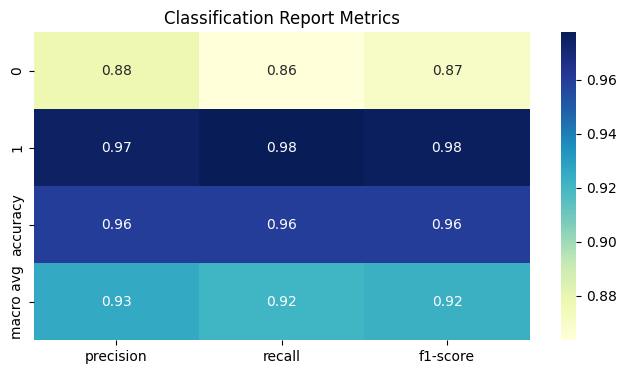

In [28]:
from sklearn.metrics import classification_report

# Get unique labels used in y_test
unique_labels = np.unique(y_test)

# Inverse transform numeric labels to their original string names
class_names = label_encoder.inverse_transform(unique_labels)

# Generate classification report
report_dict = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Plot as heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, fmt='.2f', cmap='YlGnBu')
plt.title("Classification Report Metrics")
plt.show()


# 4. Bar Plot of Sentiment Distribution in Dataset

<ipython-input-29-22d8d52787cb>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_labels, y=sentiment_counts.values, palette='pastel')


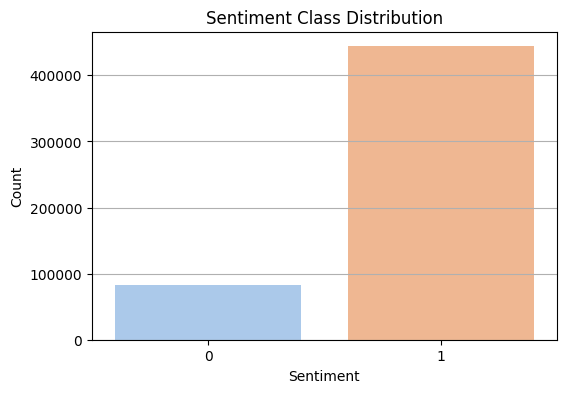

In [29]:
sentiment_counts = df['Sentiment'].value_counts()
sentiment_labels = label_encoder.inverse_transform(sentiment_counts.index)

plt.figure(figsize=(6,4))
sns.barplot(x=sentiment_labels, y=sentiment_counts.values, palette='pastel')
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.grid(True, axis='y')
plt.show()


#  5. Word Cloud (Optional but Fancy)

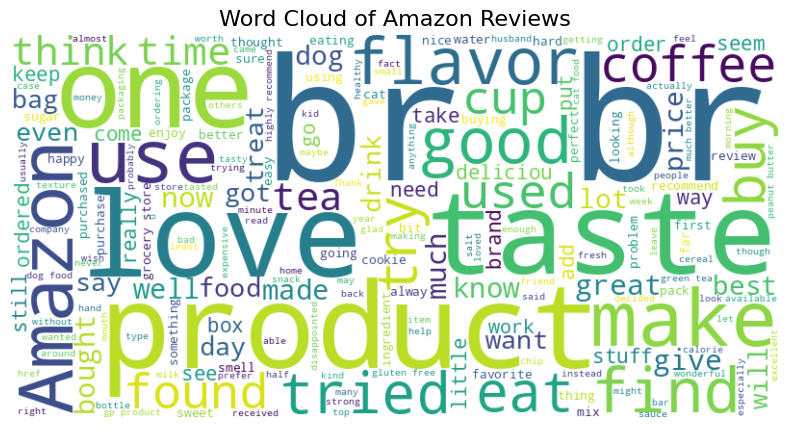

In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = ' '.join(df['Text'])

# Generate the Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Amazon Reviews", fontsize=16)
plt.show()


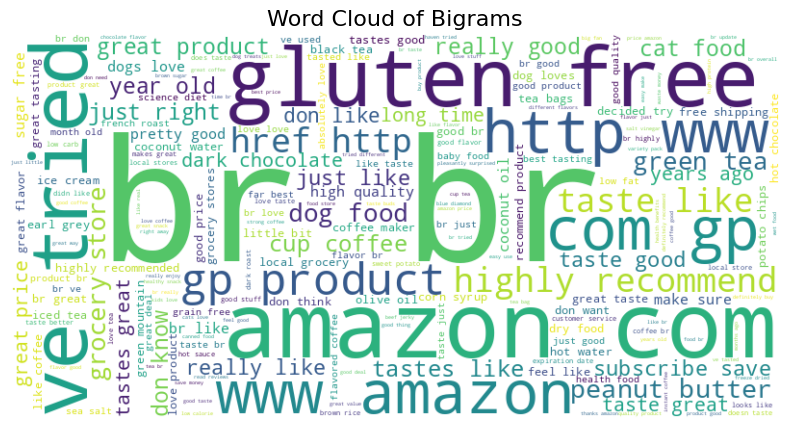

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

# Bigram model
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
ngrams = vectorizer.fit_transform(df['Text'])
ngram_freq = ngrams.sum(axis=0).A1
ngram_terms = vectorizer.get_feature_names_out()
bigrams = dict(zip(ngram_terms, ngram_freq))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigrams)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Bigrams", fontsize=16)
plt.show()


### **Declaration**

I, Harshad Jadhav, confirm that the work submitted in this assignment is my own and has been completed following academic integrity guidelines. The code is uploaded on my GitHub repository account, and the repository link is provided below:

GitHub Repository Link: https://github.com/Harshad071/Deep_Learning_Assignment_5.3

Signature: Harshad Manoj Jadhav